In this Kernel we'll take a look at the data, analyze it, clean it and then at the end make predictions for its testing set with a BRET model. Watch the videos to gain a better insight of the coding process and learn about the model. I hope this kernel will be useful for you and if you found it helpful please give this kernel and the videos an upvote! You can ask your questions here or on YouTube. I'll also link the most inspiring resources at the end of this notebook.

Also, if you'd like to read and learn more about Word Embeddings and read all the instructions check out [this medium article](https://medium.com/p/e22043291ac4/edit).

*  [Analysis](#Analysis)
*  [Word Embeddings](#Word_Embeddings)
*  [BERT in code](#BERT)

In [ ]:
%%HTML
<a id="Analysis"></a>
<center>
<iframe width="700" height="315" src="https://www.youtube.com/embed/vEzQ2NBq3fA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" style="position: relative;top: 0;left: 0;" allowfullscreen ng-show="showvideo"></iframe>
</center>

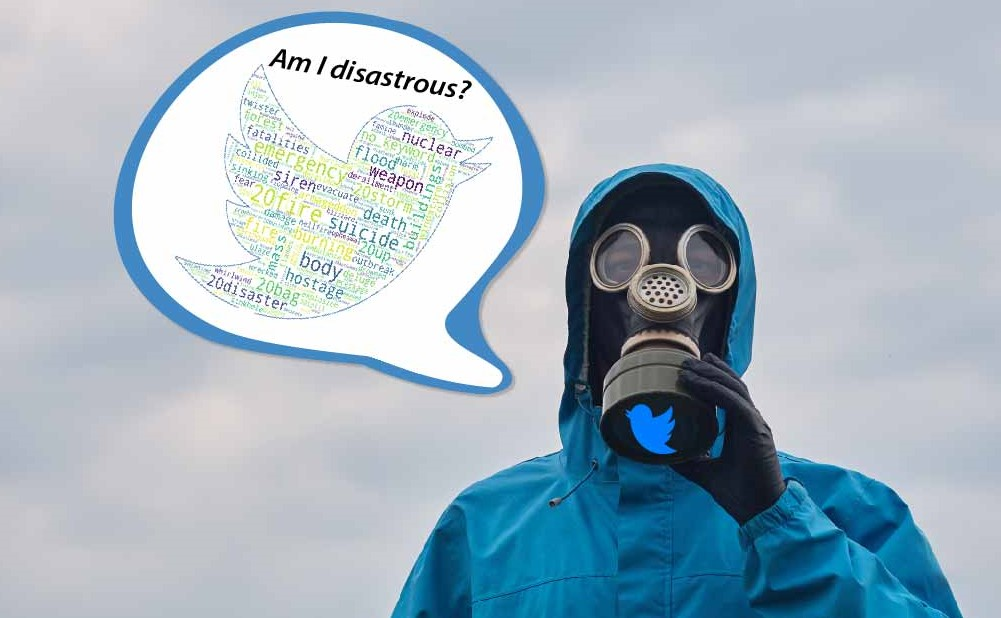

In [ ]:
# pip install sentencepiece
# pip install tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

In [ ]:
import pandas as pd
import numpy as np

# For cleaning the text
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

# For building our model
import tensorflow.keras
import sklearn
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D

In [ ]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
ids = test.id

print('Total length of the dataset: ', len(train)+len(test))
print('shape of training set: ', train.shape)
print('shape of testing set: ', test.shape)

In [ ]:
# Detecting null values and records

df_concat = pd.concat([train, test], axis = 0).reset_index(drop = True)
nulls = pd.DataFrame(np.c_[df_concat.isnull().sum(), (df_concat.isnull().sum()/ len(df_concat))*100],
                     columns = ['# of nulls', '% of nulls'],
                     index = df_concat.columns)
nulls

## Exploring The Locations and Keywords

In [ ]:
for df in [train, test, df_concat]:

    df.keyword.fillna('no_keyword', inplace = True)
    df.location.fillna('no_location', inplace = True)

###  **Location**

In [ ]:
df_concat.groupby(['location']).count().text.sort_values(ascending = False)

In [ ]:
# top 30 locations in the dataset

top_30 = df_concat.groupby(['location']).count().text.sort_values(ascending = False)[:30]

# plot the top 30

plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index);
plt.xlabel('number of tweets');


### **KeyWord**

In [ ]:
# top 20 keywords in disastrous and non_disastrous tweets
# We'll use training set for this 

count_dis_keywords = train[train.target == 1].groupby(['keyword']).count().sort_values(by = 'target', ascending = False)[:20]

count_non_dis_keywords =  train[train.target == 0].groupby(['keyword']).count().sort_values(by = 'target', ascending = False)[:20]

sns.set(style="white")


fig, ax_ = plt.subplots(1, 2, figsize = (25,10));

# left side, the plot for keywords in disastrous tweets

sns.barplot(x = count_dis_keywords.target, # count of each keyword
            y = count_dis_keywords.index, # index of this df is our keywords
            ax = ax_[0],
            palette = 'Reds_r', label = 'dis')
    


# right side, the plot for non_disastrous tweets

sns.barplot(x = count_non_dis_keywords.target, y = count_non_dis_keywords.index, 
            ax = ax_[1], palette = 'Greens_d', label = 'non_dis')


for ax in [ax_[0], ax_[1]]:
    
    ax.set_title('Number of tweets per keyword', fontsize = 20) # setting title
    
    ax.set_ylabel('') 
    ax.set_xlabel('')

    ax.set_yticklabels(labels =ax.get_yticklabels() ,
                       fontsize = 15)

In [ ]:
for df in [train, test, df_concat]:

    df.drop(columns = ['location', 'keyword', 'id'], inplace = True)

# **Cleaning the Data!**

In [ ]:
nlp = spacy.load("en")
sp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')

# spacy (362 words)
spacy_st = nlp.Defaults.stop_words
# nltk(179 words)
nltk_st = stopwords.words('english')

def clean(tweet, http = True, punc = True, lem = True, stop_w = True):
    
    if http is True:
        tweet = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', tweet)

    # stop words
    # in here I changed the placement of lower for those of you who want to use
    # Cased BERT later on.
    if stop_w == 'nltk':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in nltk_st]
        tweet = ' '.join(tweet)

    elif stop_w == 'spacy':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in spacy_st]
        tweet = ' '.join(tweet)

    # lemmitizing
    if lem == True:
        lemmatized = [word.lemma_ for word in sp(tweet)]
        tweet = ' '.join(lemmatized)

    # punctuation removal
    if punc is True:
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
        
    # removing extra space
    tweet = re.sub("\s+", ' ', tweet)
    
    return tweet

**How we are going to clean:**

clean(x, lem = False, stop_w = 'nltk', http = True, punc = True)

In [ ]:
df_concat['cleaned_text'] = df_concat.text.apply(lambda x: clean(x, lem = False, stop_w = 'nltk', http = True, punc = True))

In [ ]:
cleaned_train = df_concat[:train.shape[0]]
cleaned_test = df_concat[train.shape[0]:]

Definition of Word embeddings and how Bert uses them:

In [ ]:
%%HTML
<a id = "Word_Embeddings"></a>
<center>
<iframe width="700" height="315" src="https://www.youtube.com/embed/t5wdTK-QtLA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" style="position: relative;top: 0;left: 0;" allowfullscreen ng-show="showvideo"></iframe>
</center>

# **BERT and Word Embeddings!**

Follow along with the coding:

In [ ]:
%%HTML
<a id = "BERT"></a>
<center>
<iframe width="700" height="315" src="https://www.youtube.com/embed/wh6x2UrCO4Y" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" style="position: relative;top: 0;left: 0;" allowfullscreen ng-show="showvideo"></iframe>
</center>

In [ ]:
# Bert Tokenizer for all of them

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tokenization
FullTokenizer = tokenization.FullTokenizer


In [ ]:
ans = input("Which Bert should I use? \n a. Base uncased \n b. Large uncased \n c. Basic cased \n d. Large cased \n")

if ans is 'a':
    BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
    disc = 'Base_uncased'
elif ans is 'b':
    BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2' 
    disc = 'Large_uncased'
elif ans is 'c':
    BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2'
    disc = 'Base_cased'
elif ans is 'd':
    BERT_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/2'
    disc = 'Large_cased'

bert_layer = hub.KerasLayer(BERT_MODEL_HUB, trainable=True)
print('Bert layer is ready to use!')



if ans =='a' or ans =='b':
    to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

    tokenizer = FullTokenizer(vocabulary_file, to_lower_case)
    

    
elif ans =='c' or ans =='d':
    
    vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    
    tokenizer = FullTokenizer(vocabulary_file, do_lower_case=False)


print('Bert Tokenizer is ready!!!')


In [ ]:
# put your own sentence here, try words like openminded, undercover, etc., and see what you get
sentence = 'Terrorist will crush the Tower'
print('Tokenized version of {} is : \n {} '.format(sentence, tokenizer.tokenize(sentence)))

In [ ]:
def tokenize_tweets(text_):
    return tokenizer.convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(text_) + ['[SEP]'])

df_concat['tokenized_tweets'] = df_concat.cleaned_text.apply(lambda x: tokenize_tweets(x))

cleaned_train.head(2)

In [ ]:
# what is the maximum length of our tokenized text?

max_len = len(max(df_concat.tokenized_tweets, key = len))


print('The maximum length of each sequence besed on tokenized tweets is:', max_len)

df_concat['padded_tweets'] = df_concat.tokenized_tweets.apply(lambda x: x + [0] * (max_len - len(x)))
df_concat.head(2)

# Constructing the model!

In [ ]:
class TweetClassifier:
    
    def __init__(self, tokenizer, bert_layer, max_len, lr = 0.0001,
                 epochs = 15, batch_size = 32,
                 activation = 'sigmoid', optimizer = 'SGD',
                 beta_1=0.9, beta_2=0.999, epsilon=1e-07,
                 metrics = 'accuracy', loss = 'binary_crossentropy'):
        
        self.lr = lr
        self.epochs = epochs
        self.max_len = max_len
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.bert_layer = bert_layer
        

        self.activation = activation
        self.optimizer = optimizer
        
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon =epsilon
        
        self.metrics = metrics
        self.loss = loss

        
    def encode(self, texts):
        
        all_tokens = []
        masks = []
        segments = []
        
        for text in texts:
            
            tokenized = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + self.tokenizer.tokenize(text) + ['[SEP]'])
            
            len_zeros = self.max_len - len(tokenized)
            
            
            padded = tokenized + [0] * len_zeros
            mask = [1] * len(tokenized) + [0] * len_zeros
            segment = [0] * self.max_len
            
            all_tokens.append(padded)
            masks.append(mask)
            segments.append(segment)
        
        return np.array(all_tokens), np.array(masks), np.array(segments)


    def make_model(self):
        
        # Shaping the inputs to our model
        
        input_ids = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_ids')
        
        input_mask = Input(shape = (self.max_len, ), dtype = tf.int32, name = 'input_mask')
        
        segment_ids = Input(shape = (self.max_len, ), dtype = tf.int32,  name = 'segment_ids')

        
        pooled_output, sequence_output = bert_layer([input_ids, input_mask, segment_ids] )



        clf_output = sequence_output[:, 0, :]
        
        out = tf.keras.layers.Dense(1, activation = self.activation)(clf_output)
        
        
        model = Model(inputs = [input_ids, input_mask, segment_ids], outputs = out)
        
        # define the optimizer

        if self.optimizer is 'SGD':
            optimizer = SGD(learning_rate = self.lr)

        elif self.optimizer is 'Adam': 
            optimizer = Adam(learning_rate = self.lr, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)

        model.compile(loss = self.loss, optimizer = self.optimizer, metrics = [self.metrics])
        
        print('Model is compiled with {} optimizer'.format(self.optimizer))
        
        return model
    
    
    
    
    def train(self, x):    
        
        checkpoint = ModelCheckpoint('model.h5', monitor='val_loss',
                                     save_best_only=True)
            
        
        model = self.make_model()
        
        X = self.encode(x['cleaned_text'])
        Y = x['target']
        
        model.fit(X, Y, shuffle = True, validation_split = 0.2, 
                  batch_size=self.batch_size, epochs = self.epochs,
                  callbacks=[checkpoint])
                
        print('Model is fit!')
        
            
    def predict(self, x):
        
        X_test_encoded = self.encode(x['cleaned_text'])
        best_model = tf.keras.models.load_model('model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
        y_pred = best_model.predict(X_test_encoded)
        
        
        return y_pred


In [ ]:
classifier = TweetClassifier(tokenizer = tokenizer, bert_layer = bert_layer,
                              max_len = max_len, lr = 0.0001,
                              epochs = 3,  activation = 'sigmoid',
                              batch_size = 32,optimizer = 'SGD',
                              beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [ ]:
classifier.train(cleaned_train)

* **Optional**: You can check your score with the perfect_submission file available on Kaggle. I copied the file and cleaned it for easier use.

In [ ]:
!git clone https://github.com/mitramir55/Kaggle_NLP_competition.git
perfection = pd.read_csv('Kaggle_NLP_competition/perfect_submission.csv')

In [ ]:
y_pred = np.round(classifier.predict(cleaned_test))
print('The score of prediction: ', sklearn.metrics.f1_score(perfection.target, y_pred, average = 'micro'))

In [ ]:
# Submission
sample_sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
ids = sample_sub.id
final_submission = pd.DataFrame(np.c_[ids, y_pred.astype('int')], columns = ['id', 'target'])
final_submission.to_csv('final_submission.csv', index = False)
final_submission.head()

Some inspiring and very useful notebooks:
* [Gunes Evitan](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)
* [Shahules](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove)
* [help in Stackoverflow](https://stats.stackexchange.com/questions/246512/convolutional-layers-to-pad-or-not-to-pad)